In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import itertools
from os import path
import pickle
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 13]

import pandas as pd
pd.options.display.width = 500

slam_node_colors = {'gmapping': 'orange', 'slam_toolbox': 'blue', 'hector_slam': 'cyan'}


In [2]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        return cache_dict['df']

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [3]:
# load data from cache and rename columns
df_new_config = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")
df_many_odoms = load_cache("/home/enrico/ds/performance_modelling/output/slam_many_odoms/run_data_per_waypoint_cache.pkl")
df = df_new_config.append(df_many_odoms, ignore_index=True, sort=False)

df.rename(inplace=True, columns={
    'trajectory_length_trajectory_length': 'trajectory_length',
    'waypoint_relative_localization_error_translation_error_final': 'translation_error',
    'waypoint_absolute_localization_error_absolute_translation_error_start': 'absolute_translation_error',
    'waypoint_relative_localization_error_rotation_error_final': 'rotation_error',
#     'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs_cont',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr_cont',
    'waypoint_start_time': 'start_time_cont',
})

# refactor and extract additional parameters and metrics
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df['beta'] = df['beta'].apply(lambda x: max(x))
df['norm_translation_error'] = df.translation_error / df.trajectory_length
df['run_id'] = df['run_folder'].apply(lambda x: path.basename(x))
df['waypoint_index'] = df.sort_values('start_time_cont').groupby(df.run_id).cumcount()
df['accumulated_trajectory_length_cont'] = df.sort_values('start_time_cont').groupby(df.run_id).trajectory_length.cumsum() - df.trajectory_length
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df['p'] = df.translation_error.apply(lambda x: x > 0.2)

# discretize continuous input metrics
# df['tgs'] = pd.cut(df.tgs_cont, 5, labels=False)
df['lvr'] = pd.cut(df.lvr_cont, 10, labels=False)
df['start_time'] = pd.cut(df.start_time_cont, 10, labels=False)
df['accumulated_trajectory_length'] = pd.cut(df.accumulated_trajectory_length_cont, 10, labels=False)

# drop unnecessary datapoints
df = df[(
    ((df.slam_node == 'gmapping') | (df.slam_node == 'slam_toolbox')) & (df.linear_update == 0.5) |
    (df.slam_node == 'hector_slam') & (df.linear_update == 0.4)
)]
# df = df[((df.slam_node == 'gmapping') | (df.slam_node == 'slam_toolbox')) & (df.linear_update == 0.5)]
# df = df[df.trajectory_length > 1]
# df = df[df.absolute_translation_error < 5]

# only keep necessary columns
robot_parameters = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
]
other_parameters = [
    'run_absolute_start_time',
    'session_id',
    'run_number',
    'run_id',
    'slam_node',
    'environment_name',
]
input_discretized_metrics = [
    'start_time',
    'accumulated_trajectory_length',
#     'tgs',
    'lvr',
]
input_continuous_metrics = [
    'waypoint_index',
    'start_time_cont',
#     'tgs_cont',
    'lvr_cont',
]
output_metrics = [
    'normalized_cpu_time',
    'absolute_translation_error',
    'p',
]
df = df[
    robot_parameters +
    other_parameters +
    input_discretized_metrics +
    input_continuous_metrics +
    output_metrics
]

# for this metric we only want to 
df = df.groupby(['run_id']).aggregate(np.max)

mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
betas_fovs = list(itertools.product(betas, fovs))

printmd("## Parameters and Their Values")
for c in robot_parameters + input_discretized_metrics + ['slam_node', 'environment_name',]:
    printmd("{:>35}".format(c), sorted(list(df[c].unique())))

## Parameters and Their Values

               laser_scan_max_range [3.5, 8.0, 15.0, 30.0]

                 laser_scan_fov_deg [90, 180, 270, 359]

                               beta [0.0, 0.5, 1.0, 1.5, 2.0]

                         start_time [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

      accumulated_trajectory_length [0, 1, 2, 3, 4, 5, 6, 8, 9]

                                lvr [6.0, 7.0, 8.0, 9.0]

                          slam_node ['gmapping', 'hector_slam', 'slam_toolbox']

                   environment_name ['7A-2', 'airlab', 'fr079', 'office_b']

In [4]:
output_metric = df.normalized_cpu_time

### Model from aggregated datapoints

           slam_node |      r2

            gmapping | +0.9290

        slam_toolbox | +0.9577

         hector_slam | +0.7816

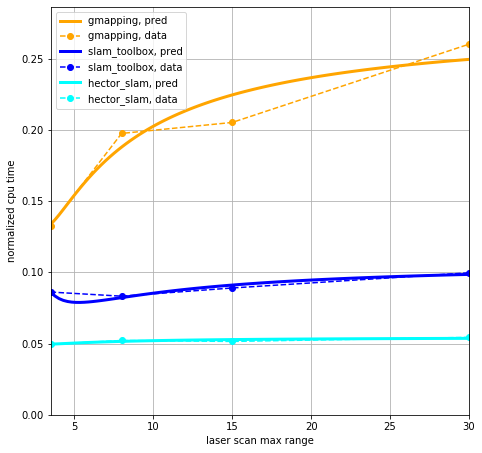

In [5]:
num_polynomial_features = 2
model_feature = df.laser_scan_max_range

def feature_transform(x):
    return 1/x

model_agg = dict()
model_all = dict()
df_agg = dict()

printmd("### Model from aggregated datapoints")
printmd(f"{'slam_node':>20} | {'r2':>7}")
for slam_node in df.slam_node.unique():
    
    df_agg[slam_node] = df[df.slam_node == slam_node].groupby(model_feature).mean()[output_metric.name]
    X_agg = (feature_transform(np.array(list(df_agg[slam_node].index.values)))).reshape(-1, 1)
    y_agg = df_agg[slam_node].values

    model_agg[slam_node] = make_pipeline(StandardScaler(), PolynomialFeatures(num_polynomial_features), LinearRegression())
    model_agg[slam_node].fit(X_agg, y_agg);

    y_pred_agg = model_agg[slam_node].predict(X_agg)
    r2_agg = r2_score(y_agg, y_pred_agg)

    printmd(f"{slam_node:>20} | {r2_agg:+0.4f}")

n = 100
plt.figure(figsize=1.5*np.array([5, 5]))

model_feature_ls = np.linspace(model_feature.min(), model_feature.max(), n)
model_feature_values = model_feature.unique()

X_predict = (feature_transform(model_feature_ls)).reshape(-1, 1)

for slam_node in df.slam_node.unique():
    y_predict = model_agg[slam_node].predict(X_predict)
    plt.plot(model_feature_ls, y_predict, linewidth=3, color=slam_node_colors[slam_node], label=f"{slam_node}, pred")
    plt.plot(df_agg[slam_node].index.values, df_agg[slam_node].values, '--o', color=slam_node_colors[slam_node], label=f"{slam_node}, data")
plt.xlim([model_feature.min(), model_feature.max()])
plt.ylim([0.0, 1.1*max(max(df_agg["slam_toolbox"].values), max(df_agg["gmapping"].values))])
plt.xlabel(f"{model_feature.name.replace('_', ' ')}")
plt.ylabel(f"{output_metric.name.replace('_', ' ')}")
plt.legend()
plt.grid()
plt.show()

### Model from aggregated datapoints

           slam_node |      r2

            gmapping | +0.9795

        slam_toolbox | +0.9986

         hector_slam | +0.5527

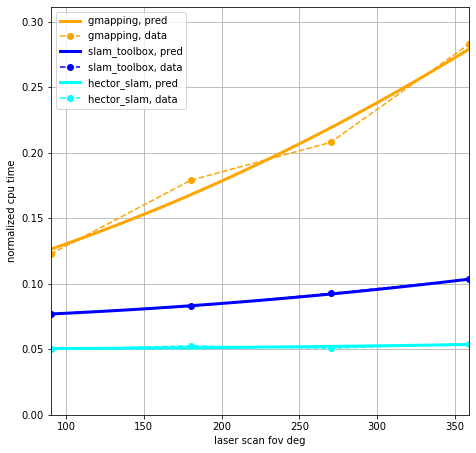

In [6]:
num_polynomial_features = 2
model_feature = df.laser_scan_fov_deg

def feature_transform(x):
    return x

model_agg = dict()
model_all = dict()
df_agg = dict()

printmd("### Model from aggregated datapoints")
printmd(f"{'slam_node':>20} | {'r2':>7}")
for slam_node in df.slam_node.unique():
    
    df_agg[slam_node] = df[df.slam_node == slam_node].groupby(model_feature).mean()[output_metric.name]
    X_agg = (feature_transform(np.array(list(df_agg[slam_node].index.values)))).reshape(-1, 1)
    y_agg = df_agg[slam_node].values

    model_agg[slam_node] = make_pipeline(StandardScaler(), PolynomialFeatures(num_polynomial_features), LinearRegression())
    model_agg[slam_node].fit(X_agg, y_agg);

    y_pred_agg = model_agg[slam_node].predict(X_agg)
    r2_agg = r2_score(y_agg, y_pred_agg)

    printmd(f"{slam_node:>20} | {r2_agg:+0.4f}")

n = 100
plt.figure(figsize=1.5*np.array([5, 5]))

model_feature_ls = np.linspace(model_feature.min(), model_feature.max(), n)
model_feature_values = model_feature.unique()

X_predict = (feature_transform(model_feature_ls)).reshape(-1, 1)

for slam_node in df.slam_node.unique():
    y_predict = model_agg[slam_node].predict(X_predict)
    plt.plot(model_feature_ls, y_predict, linewidth=3, color=slam_node_colors[slam_node], label=f"{slam_node}, pred")
    plt.plot(df_agg[slam_node].index.values, df_agg[slam_node].values, '--o', color=slam_node_colors[slam_node], label=f"{slam_node}, data")
plt.xlim([model_feature.min(), model_feature.max()])
plt.ylim([0.0, 1.1*max(max(df_agg["slam_toolbox"].values), max(df_agg["gmapping"].values))])
plt.xlabel(f"{model_feature.name.replace('_', ' ')}")
plt.ylabel(f"{output_metric.name.replace('_', ' ')}")
plt.legend()
plt.grid()
plt.show()

### Model from aggregated datapoints

           slam_node |      r2

            gmapping | +0.9599

        slam_toolbox | +0.8924

         hector_slam | +0.8735

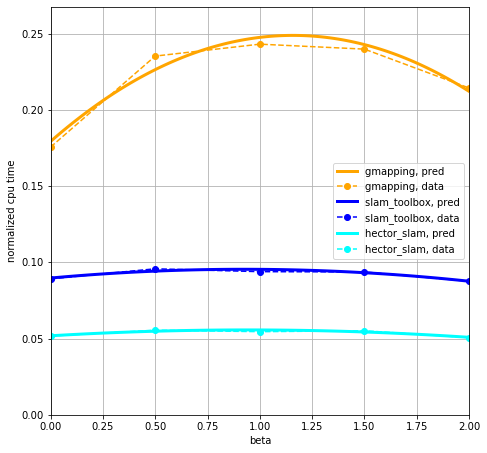

In [7]:
num_polynomial_features = 2
model_feature = df.beta

def feature_transform(x):
    return x

model_agg = dict()
model_all = dict()
df_agg = dict()

printmd("### Model from aggregated datapoints")
printmd(f"{'slam_node':>20} | {'r2':>7}")
for slam_node in df.slam_node.unique():
    
    df_agg[slam_node] = df[df.slam_node == slam_node].groupby(model_feature).mean()[output_metric.name]
    X_agg = (feature_transform(np.array(list(df_agg[slam_node].index.values)))).reshape(-1, 1)
    y_agg = df_agg[slam_node].values

    model_agg[slam_node] = make_pipeline(StandardScaler(), PolynomialFeatures(num_polynomial_features), LinearRegression())
    model_agg[slam_node].fit(X_agg, y_agg);

    y_pred_agg = model_agg[slam_node].predict(X_agg)
    r2_agg = r2_score(y_agg, y_pred_agg)

    printmd(f"{slam_node:>20} | {r2_agg:+0.4f}")

n = 100
plt.figure(figsize=1.5*np.array([5, 5]))

model_feature_ls = np.linspace(model_feature.min(), model_feature.max(), n)
model_feature_values = model_feature.unique()

X_predict = (feature_transform(model_feature_ls)).reshape(-1, 1)

for slam_node in df.slam_node.unique():
    y_predict = model_agg[slam_node].predict(X_predict)
    plt.plot(model_feature_ls, y_predict, linewidth=3, color=slam_node_colors[slam_node], label=f"{slam_node}, pred")
    plt.plot(df_agg[slam_node].index.values, df_agg[slam_node].values, '--o', color=slam_node_colors[slam_node], label=f"{slam_node}, data")
plt.xlim([model_feature.min(), model_feature.max()])
plt.ylim([0.0, 1.1*max(max(df_agg["slam_toolbox"].values), max(df_agg["gmapping"].values))])
plt.xlabel(f"{model_feature.name.replace('_', ' ')}")
plt.ylabel(f"{output_metric.name.replace('_', ' ')}")
plt.legend()
plt.grid()
plt.show()

### Model from aggregated datapoints

           slam_node |      r2

            gmapping | +0.9909

        slam_toolbox | +0.9709

         hector_slam | +0.7797

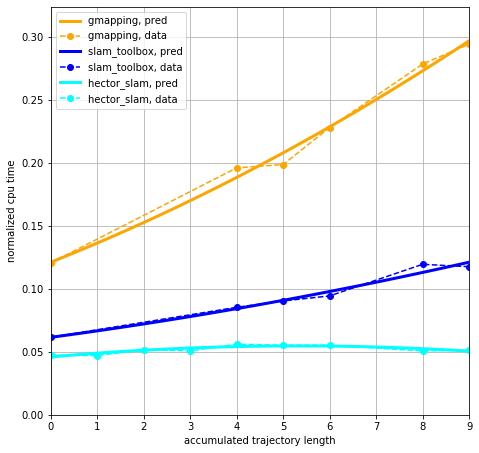

In [8]:
num_polynomial_features = 2
model_feature = df.accumulated_trajectory_length

def feature_transform(x):
    return x

model_agg = dict()
model_all = dict()
df_agg = dict()

printmd("### Model from aggregated datapoints")
printmd(f"{'slam_node':>20} | {'r2':>7}")
for slam_node in df.slam_node.unique():
    
    df_agg[slam_node] = df[df.slam_node == slam_node].groupby(model_feature).mean()[output_metric.name]
    X_agg = (feature_transform(np.array(list(df_agg[slam_node].index.values)))).reshape(-1, 1)
    y_agg = df_agg[slam_node].values

    model_agg[slam_node] = make_pipeline(StandardScaler(), PolynomialFeatures(num_polynomial_features), LinearRegression())
    model_agg[slam_node].fit(X_agg, y_agg);

    y_pred_agg = model_agg[slam_node].predict(X_agg)
    r2_agg = r2_score(y_agg, y_pred_agg)

    printmd(f"{slam_node:>20} | {r2_agg:+0.4f}")

n = 100
plt.figure(figsize=1.5*np.array([5, 5]))

model_feature_ls = np.linspace(model_feature.min(), model_feature.max(), n)
model_feature_values = model_feature.unique()

X_predict = (feature_transform(model_feature_ls)).reshape(-1, 1)

for slam_node in df.slam_node.unique():
    y_predict = model_agg[slam_node].predict(X_predict)
    plt.plot(model_feature_ls, y_predict, linewidth=3, color=slam_node_colors[slam_node], label=f"{slam_node}, pred")
    plt.plot(df_agg[slam_node].index.values, df_agg[slam_node].values, '--o', color=slam_node_colors[slam_node], label=f"{slam_node}, data")
plt.xlim([model_feature.min(), model_feature.max()])
plt.ylim([0.0, 1.1*max(max(df_agg["slam_toolbox"].values), max(df_agg["gmapping"].values))])
plt.xlabel(f"{model_feature.name.replace('_', ' ')}")
plt.ylabel(f"{output_metric.name.replace('_', ' ')}")
plt.legend()
plt.grid()
plt.show()